In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm as tqdm
import lightning.pytorch as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
from torchmetrics.image.fid import FrechetInceptionDistance


class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=3,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)


class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            else:
                (in_channels, out_channels) = (num_hiddens // 2, 3)

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return x_recon


class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay**self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average


class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3**0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x**2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts**2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, _) = self.quantize(x)
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
        }


class VQVAE_Trainer(pl.LightningModule):
    def __init__(
        self,
        fid_features=2048,
        in_channels=3,
        num_hiddens=128,
        num_downsampling_layers=2,
        num_residual_layers=2,
        num_residual_hiddens=32,
        embedding_dim=3,
        num_embeddings=512,
        use_ema=True,
        decay=0.99,
        epsilon=1e-5,
        beta=0.25,
        lr=2e-4,
        batch_size=32,
    ):
        super(VQVAE_Trainer, self).__init__()
        self.model = VQVAE(
            in_channels=3,
            num_hiddens=128,
            num_downsampling_layers=2,
            num_residual_layers=2,
            num_residual_hiddens=32,
            embedding_dim=1,
            num_embeddings=512,
            use_ema=True,
            decay=0.99,
            epsilon=1e-5,
        )

        self.fid = FrechetInceptionDistance(fid_features)

        self.lr = lr
        self.batch_size = batch_size
        self.beta = beta

        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)
        recon_error = F.mse_loss(out["x_recon"], x, reduction="sum")

        loss = recon_error + self.beta * out["commitment_loss"]

        self.log("train_loss", loss)
        self.log("train_recon_error", recon_error)
        self.log("train_commitment_loss", out["commitment_loss"])

        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)

        recon_error = F.mse_loss(out["x_recon"], x, reduction="sum")

        loss = recon_error + self.beta * out["commitment_loss"]

        self.log("val_loss", loss)
        self.log("val_recon_error", recon_error)
        self.log("val_commitment_loss", out["commitment_loss"])

        if batch_idx == 0:
            self.logger.experiment.log(
                {
                    "reconstructed": wandb.Image(
                        torchvision.utils.make_grid(out["x_recon"]),
                        caption=f"Epoch {self.current_epoch}, Step {self.global_step}",
                    ),
                    # "real": wandb.Image(
                    #     torchvision.utils.make_grid(x),
                    #     caption=f"Epoch {self.current_epoch}, Step {self.global_step}",
                    # ),
                }
            )

            # Resize to 299x299
            x = F.interpolate(x, size=299)
            x_hat = F.interpolate(out["x_recon"], size=299)

            # Convert to u8
            x = (x * 255).to(torch.uint8)
            x_hat = (x_hat * 255).to(torch.uint8)

            # Compute FID
            self.fid.update(x, real=True)
            self.fid.update(x_hat, real=False)

            self.log("fid", self.fid.compute())
            self.fid.reset()

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.lr)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.ImageFolder(
                "data/celeba_hq/train",
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize((128, 128)),
                        torchvision.transforms.ToTensor(),
                    ]
                ),
            ),
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.ImageFolder(
                "data/celeba_hq/val",
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize((128, 128)),
                        torchvision.transforms.ToTensor(),
                    ]
                ),
            ),
            batch_size=self.batch_size,
            shuffle=True,
        )


def main():
    vae = VQVAE_Trainer()
    wandb_logger = WandbLogger(
        project="vq-vae",
        save_code=True,
        log_model=True,
        save_dir="./projects/image-generation/6-vq-vae/logs/",
    )
    trainer = pl.Trainer(
        logger=wandb_logger,
        val_check_interval=0.5,
        limit_val_batches=1,
        log_every_n_steps=1,
        default_root_dir="./projects/image-generation/6-vq-vae/logs/",
        max_steps=10_000,
        enable_checkpointing=True,
    )
    trainer.fit(vae)


In [ ]:
model = VQVAE_Trainer.load_from_checkpoint("projects/paper-implementations/image-generation/6-vq-vae/checkpoints/epoch=10-step=9624.ckpt")


In [ ]:
og_dataset = torchvision.datasets.ImageFolder(
    "data/celeba_hq/val",
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((128, 128)),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

og_loader = torch.utils.data.DataLoader(og_dataset, batch_size=32, shuffle=False)


In [ ]:
quantized_dataset = torch.utils.data.TensorDataset(torch.cat(
    [
        model.model.quantize(x)[3]
        for x, _ in og_loader
    ],
    dim=0
))


In [ ]:
import tqdm
import torch.nn.functional as F


In [ ]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer to predict each character
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # Embedding
        x = self.embedding(x)
        
        # Initialize hidden state and cell state if not provided
        if hidden is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device)
            hidden = (h0, c0)
        
        # LSTM output along with new hidden state
        out, hidden = self.lstm(x, hidden)
        
        # Reshape output for the fully connected layer
        out = out.reshape(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden

# Create an instance of the updated model
vocab_size = 512  # number of unique characters
embed_dim = 128   # embedding dimension
hidden_dim = 256  # LSTM hidden dimensions
num_layers = 2  # number of LSTM layers

generator = Model(vocab_size, embed_dim, hidden_dim, num_layers)
print(f"Generator has {sum(p.numel() for p in generator.parameters() if p.requires_grad):,} parameters")


In [ ]:
# Load .pt file
quantized_dataset = torch.load("quantized.pt")


In [ ]:
quantized_loader = torch.utils.data.DataLoader(quantized_dataset, batch_size=16, shuffle=True)
x = next(iter(quantized_loader))
print(x[0].shape)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(generator.parameters(), lr=0.001)


In [61]:
max_length = 1024  # Max length for padding
generator.train()
with tqdm.notebook.tqdm(range(10), desc="Epochs", leave=False) as epochs:
    for epoch in epochs:
        with tqdm.notebook.tqdm(quantized_loader, leave=False, desc="Batches") as progress:
            for x_batch in progress:
                x_batch = x_batch[0]  # Assuming DataLoader returns a tuple

                hidden = None  # Reset hidden state for each new sequence
                total_loss = torch.tensor(0.0)  # Reset total loss for each new sequence
                optimizer.zero_grad()  # Reset gradients

                with tqdm.notebook.tnrange(0, x_batch.size(1)-1, leave=False, desc="Character") as seq:
                    for i in seq: 
                        x_in = x_batch[:, i]
                        y_out = x_batch[:, i + 1] 

                        # x_in = F.pad(x_in, (0, max_length - x_in.size(0)), value=0)
                        
                        y_hat, hidden = generator(x_in.unsqueeze(0), hidden)
                        y_pred = torch.argmax(y_hat, dim=-1)
                        # print(y_pred.shape, y_out.shape)
                        loss = criterion(y_hat.squeeze(0), y_out)
                        
                        total_loss += loss
                        progress.set_postfix_str(f"loss={loss.item():.3f}, total_loss={total_loss.item():.3f}")
                                                
                total_loss.backward()
                optimizer.step()
                
                progress.set_postfix_str(f"loss={loss.item():.3f}, total_loss={total_loss.item():.3f}")


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

Character:   0%|          | 0/1023 [00:00<?, ?it/s]

In [1]:
import matplotlib.pyplot as plt 
@torch.no_grad()
def temperature_sampling(logits, temperature=0.7):
    # Scale logits by temperature
    scaled_logits = logits / temperature
    # Convert logits to probabilities
    probs = F.softmax(scaled_logits, dim=-1)
    # Sample from the probabilities
    return torch.multinomial(probs, num_samples=1)

# Validation Loop with Temperature Sampling
generator.eval()
model.eval()
initial_input = torch.randint(0, vocab_size, (1, 1))
print(initial_input)
generated_indexes = []
generated_indexes.append(initial_input.flatten())
hidden = None

with torch.no_grad():
    for _ in range(1023):  # Generate 64 characters
        # print(initial_input.shape)
        output, hidden = generator(initial_input, hidden)  # Ensure model accepts and returns hidden state
        predicted = torch.argmax(output, dim=-1)
        generated_indexes.append(predicted)
        initial_input = predicted.unsqueeze(0)  # Set the next input to the predicted character


    embeddings = F.embedding(
        torch.cat(generated_indexes).unsqueeze(0).unsqueeze(0),
        model.model.vq.e_i_ts.transpose(0, 1)
    ).permute(0, 3, 1, 2).view(-1, 1, 32, 32)
    print(embeddings.shape)
    img = model.model.decoder(embeddings)
    print(img.shape)

    plt.imshow(img[0].permute(1, 2, 0).detach().numpy())
    plt.axis("off")
    plt.show()


NameError: name 'torch' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9, 9, 8,  ..., 5, 1, 1])
torch.Size([1, 1, 32, 32])
torch.Size([1, 3, 128, 128])


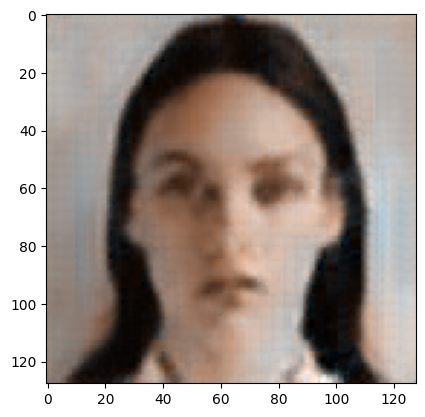

In [58]:
x = next(iter(quantized_loader))[0][0]
print(x)
import matplotlib.pyplot as plt 
# get the embeddings from indicies
with torch.no_grad():
    embeddings = F.embedding(
        x.unsqueeze(0).unsqueeze(0),
        model.model.vq.e_i_ts.transpose(0, 1)
    ).permute(0, 3, 1, 2).view(1, 1, 32, 32)
    print(embeddings.shape)
    img = model.model.decoder(embeddings)
    print(img.shape)

    plt.imshow(img[0].permute(1, 2, 0).detach().numpy())
    plt.show()
